In [1]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pingouin as pg
import scipy
import pandahouse as ph

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Задание 1. A/B–тестирование

## Загрузка данных

Решила написать функцию которая будет автоматически выгружать файлы по списку ссылок и присваивать им нужные имена переменных) Правда паттерн получился тоже специфический для этого задания, но если что в дальнейщем можно убрать то, что идет между = и группой.

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
file_urls = ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', 
             'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', 
             'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', 
             'https://disk.yandex.ru/d/pH1q-VqcxXjsVA']
# паттерн для определения имени файла
p = re.compile(r'filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_(.*).csv')

table_names = []
for url in file_urls:
    response = requests.get(base_url + urlencode(dict(public_key=url))).json()['href'] # делаем запрос
    table_names.append(p.search(response).group(1)) # сохраняем имя таблицы
    # используем 'w' как разделитель чтобы получить неразделенные данные и выделить настоящий разделитель, 
    # затем получаем первое значение из таблицы
    first_value = pd.read_csv(response, sep='w').iloc[:,0][0]
    
    # определяем разлеоитель, если в таблице один столбец, переходим к блоку except и читаем без указания разделителя
    try:
        sep = re.compile('([,;\\t])').search(first_value).group(1)
        locals()[table_names[-1]] = pd.read_csv(response, sep=sep)
    except:
        locals()[table_names[-1]] = pd.read_csv(response)

# смотрим какие таблицы выгрузились    
table_names

['groups', 'group_add', 'active_studs', 'checks']

## Исследование данных

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Таблица содержит информацию о распределении студентов по группа: А - контрольная, В - экспериментальная

Посмотрим на размеры групп

In [4]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

Экспериментальная группа больше контрольной более чем в 4 раза, что является достаточно странным решением

Посмотрим на вторую таблицу, содержащую информацию о дополнительных участниках и их группах 

In [5]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


Посмотрим сколько и из каких групп добавилось

In [6]:
group_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

Посмотрим на таблицу со студентами, которые были активными во время эксперимента, а также на размер этой таблицы

In [7]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
active_studs.shape

(8341, 1)

8341 активный студент на период проведения теста, посмотрим есть ли повторения id если студент был активен не один раз

In [9]:
active_studs.duplicated().sum()

0

Повторений нет

Также надо проверить, есть ли среди активных студентов id из дополнительного списка

In [10]:
group_add.id.isin(active_studs.student_id).sum()

13

Да, 13 человек из дополнительного списка были активны во время эксперимента

Посмотрим на таблицу с информацией об оплатах пользователей в дни проведения эксперимента

In [11]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Посмотрим были ли люди которые делали более одной покупки

In [12]:
checks.groupby('student_id').size().sort_values(ascending=False).head()

student_id
5740903    1
1281916    1
1160511    1
1182574    1
1184303    1
dtype: int64

Нет таких студентов

Скорее всего в данной таблице содержатся суммы всех покупок за период проведения эксперимента, так как удивительно что нет ни одного человека, который сделал бы больше одной покупки, но нужно это проверить.

Посмотрим какие есть уникальные значения и сколько раз они повторяются

In [13]:
checks.groupby('rev').size().sort_values(ascending=False)

rev
1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
398.0000      9
1530.0000     8
870.0000      6
3660.0000     5
1980.0000     4
2910.0000     4
2890.0000     4
1160.0000     3
489.0000      3
2099.0000     3
1180.0000     2
2220.0000     2
2820.0000     2
630.0000      1
796.0000      1
597.0000      1
4650.0000     1
880.0000      1
1039.0000     1
1050.0000     1
1388.0000     1
1729.0000     1
1830.0000     1
1968.0000     1
2190.0000     1
2900.0000     1
3040.0000     1
3260.0000     1
1339.0000     1
dtype: int64

Так как суммы являются не "ровными", то есть не похожими на стоимость конкретной услуги, при этом такие значения встречаются по 1 разу, можем предположить что переменная rev содержит информацию о сумме всех покупок сделанных за период, либо же если одна покупка содержала несколько товаров. В целом, это могут быть как первые, так и вторые случаи, а то, что мы можем сказать точно, это то, что данная переменная содержит сумму по всем покупкам товаров за период проведения теста. 

Также во время исследования данных была обнаружена аномалия: 

In [14]:
groups.merge(checks, left_on='id', right_on='student_id').shape

(540, 4)

In [15]:
active_studs.merge(checks, on='student_id').shape

(392, 2)

Если соединять таблицы с распределением по группам и покупками на период эксперимента, то получается, что 540 человек участвующих в эксперименте делали покупки, но если соединять таблицу активных пользователей на период эксперимента с таблицей покупок, то получается 392 человека, которые были активны и сделали покупки. Это какжется невозможным, так как выходит, что некоторые пользователи совершали покупки не заходя на платформу, скорее всего в данных баг и это нужно учитывать при последующей обработке данных.

Теперь определим метрики, которые мы будем оценивать

## Определение метрик

В качестве метрик мы будем использовать:
1. ARPPU - средее количество потраченных активными пользователями денег за период эксперимента, т.к. удобство механики может сподвигать пользователей делать более дорогостоящие покупки, или в принципе больше покупок, учитывая что наши данные содержат информацию о сумме потраченных денег за все покупки
2. CR в покупку - отношение количества пользователей совершивших покупку ко всем пользователям в группе, т.к. более удобная механика может мотивировать пользователя доходить до конца на этапе совершения покупки

## Предобработка данных

Создадим основную таблицу, с которой дальше будем работать. У нас имеется таблица с дополнительными пользователями, но так как для нее есть отдельное задание, где нужно будет создать функцию, которая будет подгружать эти данные и пересчитывать метрики, в данном задании не будем учитывать этих дополнительных юзеров. Однако, предврительное исследование данных показало, что в таблице с активными пользователями содержатся данные о дополнительных пользователях, а также данная таблица не содержит данные о некоторых пользователях, которые делали покупки и соответственно были активными. Исходя из этого, будет целесообразным сначала соединить таблицу с группами с таблицей с чеками, а потом добавить информацию об активности

In [13]:
# соединяем таблицы, отбирая участников эксперимента только из основного файла
data = checks.rename(columns={'student_id': 'id'}) \
    .merge(groups, on='id', how='right') \
    .merge(active_studs, left_on= 'id', right_on='student_id', how='left') 

# определяем активных юзеров как тех, кто либо есть в списке активных, либо совершил покупку, либо все вместе 
# и убераем всех остальных, так как неактивные юзеры для дальнейшего анализа нам не нужны, также убираем лишнюю колонку
data = data[-(pd.isna(data.rev) & pd.isna(data.student_id))].drop(columns='student_id')

# проверяем все ли юзеры, совершившие покупку, сохранились
data.dropna().shape

(540, 3)

Добавим также столбец для обозначения того, сконвертировался ли пользователь в покупку

In [14]:
data['conversed'] = data.apply(lambda x: 0 if pd.isna(x.rev) else 1, axis=1)
data.head()

,id,rev,grp,conversed
1,1627,990.0,A,1
10,2085,NaN,B,0
12,2215,NaN,B,0
39,3185,690.0,B,1
43,3391,NaN,A,0


Данная таблица итоговая, работать будем уже с ней

## Проверка гипотез

#### 1. ARPPU

Здесь будем учитывать только тех, кто совершал покупки

Чтобы принять решение, какой статистический тест использовать, посмотрим сначала на распределения

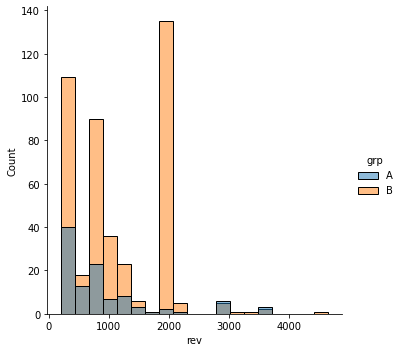

In [20]:
sns.displot(data = data, x='rev', hue='grp', bins=19)

Выборка достаточно большая, но распределения далеко не нормальные, поэтому лучше использовать бутстрап в данном случае

In [15]:
data.groupby('grp').agg({'rev': 'mean'})

,rev
grp,
A,860.710280
B,1106.997699


Н0: Средние двух групп равны

Н1: Средние двух групп различаются

In [17]:
# Создание двух выборок данных
data_A = data.dropna().query('grp == "A"').rev
data_B = data.dropna().query('grp == "B"').rev

# Функция для оценки разности медиан
def mean_difference(data1, data2):
    return np.mean(data1) - np.mean(data2)

pg.compute_bootci(x=data_A, y=data_B, func=mean_difference)

array([-446.42, -161.91])

Доверительный интервал не включает 0, поэтому можем отвергнуть нулевую гипотезу и утверждать, что средние статистически значимо отличаются

#### 2. CR в покупку

Посмотрим на конверсию в группах

In [20]:
data.groupby('grp').agg({'conversed': 'mean'})

,conversed
grp,
A,0.068414
B,0.062636


Для статистической оценки различия в конверсиях будем использовать таблицу сопряженности и критерий хи-квадрат

H0: В выборках отсутствуют различия в распределении частот

Н1: В выборках существуют различия в распределении частот

In [21]:
pg.chi2_independence(data, x='grp', y='conversed')

(conversed            0           1
 grp                               
 A          1464.370414   99.629586
 B          6472.629586  440.370414,
 conversed       0      1
 grp                     
 A          1457.5  106.5
 B          6479.5  433.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  0.620496  1.0  0.430863  0.008556  0.123550
 1        cressie-read  0.666667  0.617149  1.0  0.432109  0.008532  0.123143
 2      log-likelihood  0.000000  0.610576  1.0  0.434571  0.008487  0.122344
 3       freeman-tukey -0.500000  0.605748  1.0  0.436393  0.008453  0.121757
 4  mod-log-likelihood -1.000000  0.601007  1.0  0.438194  0.008420  0.121182
 5              neyman -2.000000  0.591775  1.0  0.441734  0.008355  0.120061)

Так как уровень значимости больше 0.05, мы не можем отвергнуть нулевую гипотезу, а значит распределения частот в группах одинаковое

## Выводы

**Описание результатов:**

Различия в контрольной и тестовой группе обнаружены по метрике ARPPU. Однако, конверсия в покупку не изменилась.

Таким образом, напрашивается вывод, что покупатели, которые использовали новую механику оплаты услуг покупали больше, что может говорить об удобстве такой механики для клиентов. В то же время, остальные студенты по всей видимости не имели информации о новой механике и поэтому конверсия в покупку не изменилась.

В целом, использование новой механики выглядит достаточно эффективным, однако, сам АБ-тест выстроен недостаточно грамотно, например, выборка несбалансированная с перекосом в экспериментальную группу, что может приводить к неточным результатам. Также,хотелось бы проверить другие метрики, такие как: конверсия из добавления в карзину в покупку, количество повторных покупок, конверсия из оформления заказа в оплату и так далее, в зависимости от того, какие изменения в механике оплаты произошли.

Также, в данных был обнаружен баг в отображении активности пользователей, что также может привести к искаженным результатам.

**Основные рекомендации:** починить баг, подобрать более подходящие метрики и соответствующие данные, сбалансировать выборки и провести тест снова. Хотя настоящий тест и дал положительный результат, я бы не рекомендовала пока распространять изменения на всех пользователей.

# Задание 2. SQL

## 2.1 Очень усердные ученики

In [32]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'}

Условие:

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

В таблице данные за 2 дня, но так как в задании указано что учитываются решенные задачи именно за месяц я решила учесть это в запросе

In [35]:
q1 = """WITH 
            (SELECT MAX(timest) - INTERVAL 1 MONTH
            FROM default.peas) as month_ago

        SELECT    
            COUNT(st_id) as diligent_studs
        FROM   
            (SELECT 
                st_id,
                SUM(correct) as sum_cor
            FROM 
                default.peas
            WHERE timest > month_ago
            GROUP BY 
                st_id
            HAVING
                sum_cor >= 20
            )
"""

In [36]:
df = ph.read_clickhouse(query=q1, connection=connection)
df

,diligent_studs
0,136


## 2.2 Оптимизация воронки

Условие:

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [62]:
q2 = """SELECT 
            test_grp,
            ROUND(SUM(money) / COUNT(DISTINCT st_id), 2) as ARPU,
            ROUND(SUM(IF(active = 1, money, 0)) / SUM(active), 2) AS ARPAU,
            ROUND(SUM(purchase) / COUNT(st_id) * 100, 2) as cr_purchase,
            ROUND(SUM(IF(active = 1, purchase, 0)) / SUM(active) * 100, 2) as cr_active_purchase,
            ROUND(SUM(IF(active_math = 1, purchase_math, 0)) / SUM(active_math) * 100, 2) as cr_active_math


        FROM
            (SELECT 
                studs.st_id as st_id,
                studs.test_grp as test_grp,
                purchase.purchase as purchase,
                active.active as active,
                active_math.active_math as active_math,
                purchase_math.purchase_math as purchase_math,
                money.money as money
            FROM studs

            JOIN
                (SELECT st_id, if(any(money) = 0, 0,1) as purchase
                FROM default.studs
                    LEFT JOIN
                        (SELECT st_id, money
                        FROM default.final_project_check) as checks
                    USING(st_id)
                    GROUP BY studs.st_id) as purchase
            ON studs.st_id = purchase.st_id

            JOIN 
                (SELECT st_id, if(sum_cor > 10, 1, 0) as active
                FROM default.studs
                LEFT JOIN
                    (SELECT 
                        st_id,
                        SUM(correct) as sum_cor
                    FROM default.peas
                    GROUP BY st_id) as peas
                USING(st_id)) as active
            ON studs.st_id = active.st_id

            JOIN
                (SELECT st_id, if(sum_cor >= 2, 1, 0) as active_math
                FROM default.studs
                LEFT JOIN
                    (SELECT 
                        st_id,
                        SUM(correct) as sum_cor
                    FROM default.peas
                    WHERE subject = 'Math'
                    GROUP BY st_id
                    ) as peas
                USING(st_id)) as active_math
            ON studs.st_id = active_math.st_id

            LEFT JOIN
                (SELECT st_id, SUM(money) as money
                FROM default.final_project_check
                GROUP BY st_id) as money
            ON studs.st_id = money.st_id

            LEFT JOIN 
                (SELECT st_id, 1 as purchase_math
                FROM default.final_project_check
                WHERE subject = 'Math'
                ) as purchase_math
            ON studs.st_id = purchase_math.st_id
            ) as table

        GROUP BY test_grp"""

In [63]:
df = ph.read_clickhouse(query=q2, connection=connection)
df

,test_grp,ARPU,ARPAU,cr_purchase,cr_active_purchase,cr_active_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


# Задание 3. Python

#### 1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [22]:
def recalculate_metrics(groups, checks, active_studs, link_to_new_df):
    
    # загрузка дополнительного файла
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    response = requests.get(base_url + urlencode(dict(public_key=link_to_new_df))).json()['href'] 
    first_value = pd.read_csv(response, sep='w').iloc[:,0][0]
    try:
        sep = re.compile('([,;\\t])').search(first_value).group(1)
        new_df = pd.read_csv(response, sep=sep)
    except:
        new_df = pd.read_csv(response)
    
    # переименовываем столбцы, на случай если их названия отличаются и соединяем таблицы
    new_df.columns = ['id', 'grp']
    groups = pd.concat([groups, new_df], ignore_index=True)
    
    # предобработка
    
    # создание итогового датафрейма для дальнейшего расчета метрик
    data = checks.rename(columns={'student_id': 'id'}) \
        .merge(groups, on='id', how='right') \
        .merge(active_studs, left_on= 'id', right_on='student_id', how='left') 
    data = data[-(pd.isna(data.rev) & pd.isna(data.student_id))].drop(columns='student_id')
    data['conversed'] = data.apply(lambda x: 0 if pd.isna(x.rev) else 1, axis=1)
    
    # расчет метрик
    mean_revenue_per_paying_user   = data.groupby('grp').agg({'rev': 'mean'})
    cr_to_purchase                 = data.groupby('grp').agg({'conversed': 'mean'})
    
    # соединяем таблицы
    df = pd.concat([mean_revenue_per_paying_user, cr_to_purchase], axis=1)
    
    return df

Применяем функцию

In [23]:
df = recalculate_metrics(groups, checks, active_studs, 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
df

,rev,conversed
grp,,
A,860.710280,0.068283
B,1108.824893,0.062690


#### 2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [24]:
def make_barplots(df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    titles = ['ARPPU',
              'CR в покупку']
    columns = ['rev', 'conversed']
    colors = ['olive', 'salmon']

    for i, ax in enumerate(axes.flatten()):
        ax.bar(df.index, df[columns[i]], color=colors[i])
        ax.set_title(titles[i])

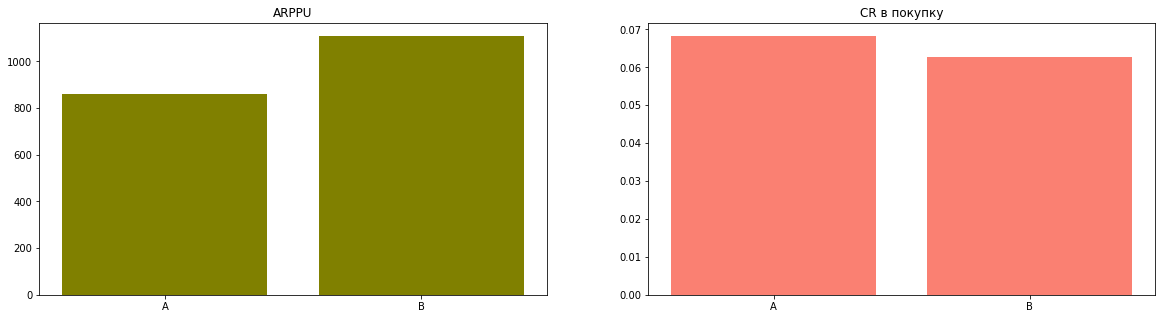

In [25]:
make_barplots(df)